# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [1]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2021-06-08 10:11:48--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 503 Service Unavailable
2021-06-08 10:11:48 ERROR 503: Service Unavailable.



Read the classes names 

In [5]:
from google.colab import files
uploaded = files.upload()

Saving mini_classes.txt to mini_classes.txt


In [6]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [7]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [8]:
!mkdir data

In [9]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [10]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports 

In [11]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [12]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [13]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [14]:
print(len(x_train))

320000


Show some random data 

umbrella


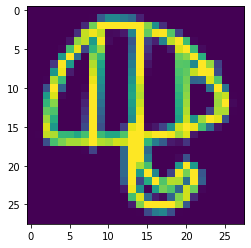

In [15]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [16]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [19]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

# Training 

In [20]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 37s - loss: 1.9772 - top_k_categorical_accuracy: 0.7711 - val_loss: 1.4192 - val_top_k_categorical_accuracy: 0.8725
Epoch 2/5
1125/1125 - 5s - loss: 1.2729 - top_k_categorical_accuracy: 0.8892 - val_loss: 1.1921 - val_top_k_categorical_accuracy: 0.8997
Epoch 3/5
1125/1125 - 5s - loss: 1.1106 - top_k_categorical_accuracy: 0.9076 - val_loss: 1.0842 - val_top_k_categorical_accuracy: 0.9107
Epoch 4/5
1125/1125 - 5s - loss: 1.0201 - top_k_categorical_accuracy: 0.9169 - val_loss: 1.0190 - val_top_k_categorical_accuracy: 0.9182
Epoch 5/5
1125/1125 - 9s - loss: 0.9598 - top_k_categorical_accuracy: 0.9228 - val_loss: 0.9972 - val_top_k_categorical_accuracy: 0.9194


# Testing 

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 91.90%


# Inference 

['circle', 'helmet', 'pillow', 'moon', 'frying_pan']


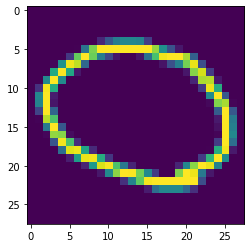

In [22]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [23]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [24]:
!pip install tensorflowjs 

  ERROR: HTTP error 404 while getting https://files.pythonhosted.org/packages/51/19/5ab51223cb178ab0f44fbc2ac494d015da135c70603a13eecb2328a59000/tensorflowjs-3.7.0-py3-none-any.whl#sha256=6ca2b623be0449ebf5d70a977bb4608b9981ef61748adb5bae043e7143218ade (from https://pypi.org/simple/tensorflowjs/)
  ERROR: Could not install requirement tensorflowjs from https://files.pythonhosted.org/packages/51/19/5ab51223cb178ab0f44fbc2ac494d015da135c70603a13eecb2328a59000/tensorflowjs-3.7.0-py3-none-any.whl#sha256=6ca2b623be0449ebf5d70a977bb4608b9981ef61748adb5bae043e7143218ade because of error 404 Client Error: Not Found for url: https://files.pythonhosted.org/packages/51/19/5ab51223cb178ab0f44fbc2ac494d015da135c70603a13eecb2328a59000/tensorflowjs-3.7.0-py3-none-any.whl
ERROR: Could not install requirement tensorflowjs from https://files.pythonhosted.org/packages/51/19/5ab51223cb178ab0f44fbc2ac494d015da135c70603a13eecb2328a59000/tensorflowjs-3.7.0-py3-none-any.whl#sha256=6ca2b623be0449ebf5d70a977bb4

# Save and Convert 

In [25]:
model.save('keras.h5')

In [26]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

/bin/bash: tensorflowjs_converter: command not found


# Zip and Download 

In [27]:
!cp class_names.txt model/class_names.txt

In [28]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/class_names.txt (deflated 42%)


In [29]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>